## Setup

In [161]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import datetime

import functools
import IPython
import IPython.display
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf


import glucose_ts

# plot layouts
sns.set_style("whitegrid")
sns.set_context(
    "talk",
    rc={
        "axes.titlesize": 36,
        "axes.labelsize": 36,
        "lines.linewidth": 3,
        "lines.markersize": 10,
        "xtick.labelsize": 24,
        "ytick.labelsize": 24,
        'legend.fontsize': 32,
        'figsize': (20, 20),
    }
)
husl_colors = sns.color_palette("husl", 12)

FIG_DIR = os.path.join(
    os.path.dirname(os.path.dirname(glucose_ts.__file__)),
    'presentations',
    'images',
)

plt.subplots_adjust(wspace=1.5)
DATA_DIR = os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'data')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

# Standards measure at 37 degree without Lucas

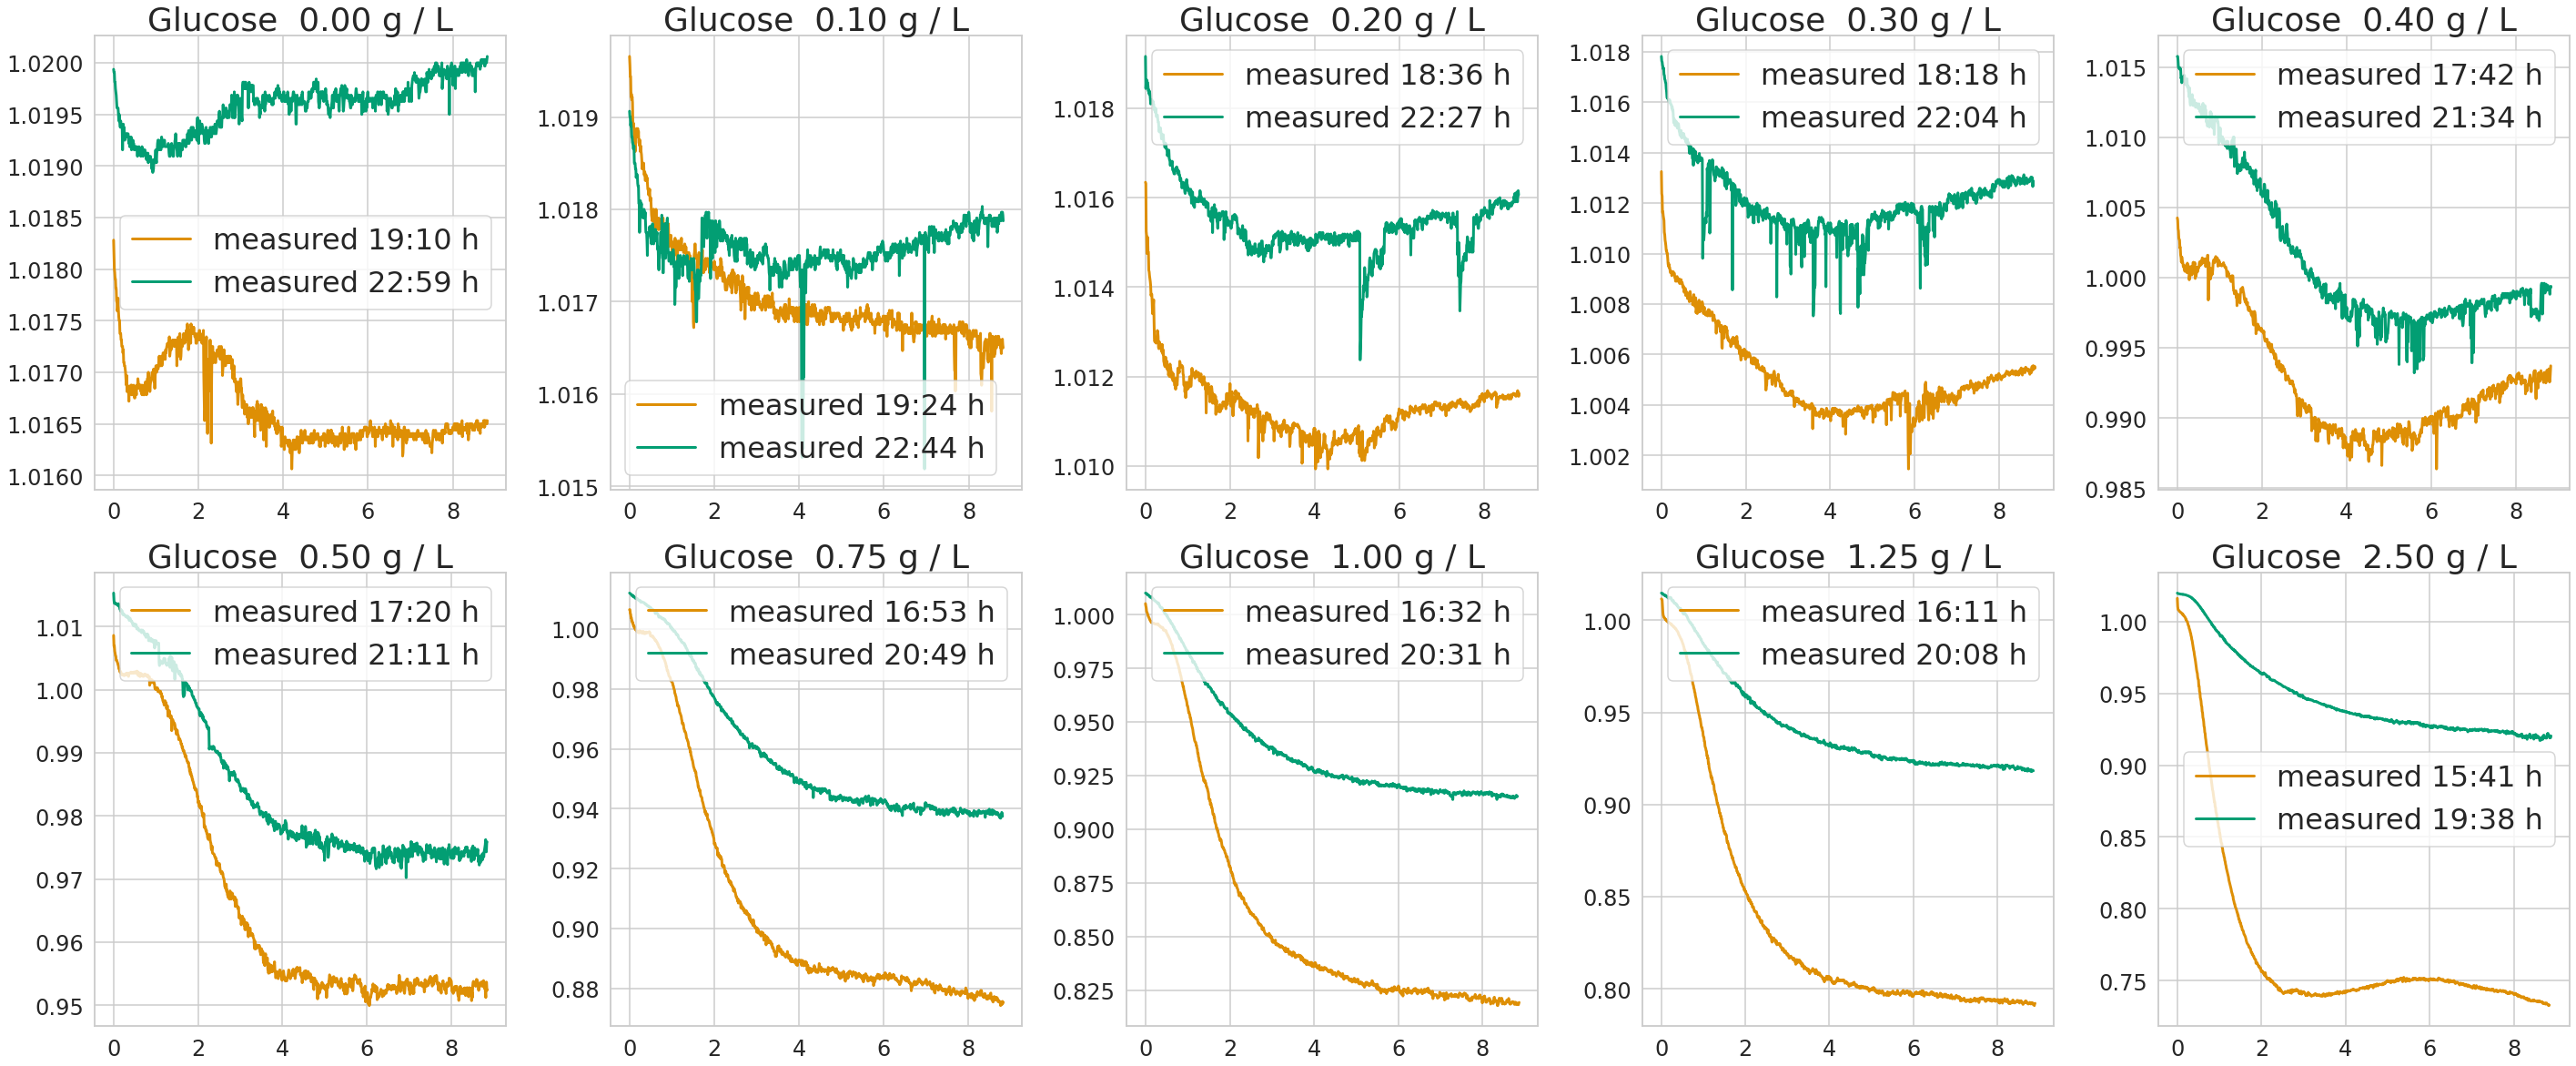

In [196]:
import itertools

def plot_by_concentration(base_path, grid):
    all_series = [
        glucose_ts.data.read_glucose_ts(
            os.path.join(base_path, one),
            comment=[int(number) for number in one.split('__')[1].split('_')[:2]],
        )
        for one in tuple(
            os.walk(base_path)
        )[0][2]
    ]
    series = itertools.groupby(
        sorted(
            all_series,
            key=lambda one: (one.real_concentration, one.comment)
        ),
        key=lambda one: one.real_concentration
    )

    num_concentrations = len(set([one.real_concentration for one in all_series]))
    fig, axises = plt.subplots(
        nrows=grid[0],
        ncols=grid[1],
        figsize=(4 * num_concentrations, 17)
    )
    fig.tight_layout(pad=2.5)
    counter = 0
    for (one_concentration, one_group), ax in zip(series, axises.flatten()):
        counter += 1
        for one_series, color in zip(one_group, sns.color_palette('colorblind', 4)[1:]):

            ax.plot(
                one_series.points_in_time,
                one_series.voltages,
                label='measured %02d:%02d h' % tuple(one_series.comment),
                color=color
            )
        ax.set_title('Glucose %5.2f g / L' % one_series.real_concentration)
        ax.legend()
        
    
    return fig

fig = plot_by_concentration(os.path.join(DATA_DIR, 'standards_warm'), grid=(2, 5))
    
fig.savefig(
    os.path.join(FIG_DIR, 'sensor_behavior_over_time.png'),
    facecolor='w',
    edgecolor='w',
    transparent=True,
)

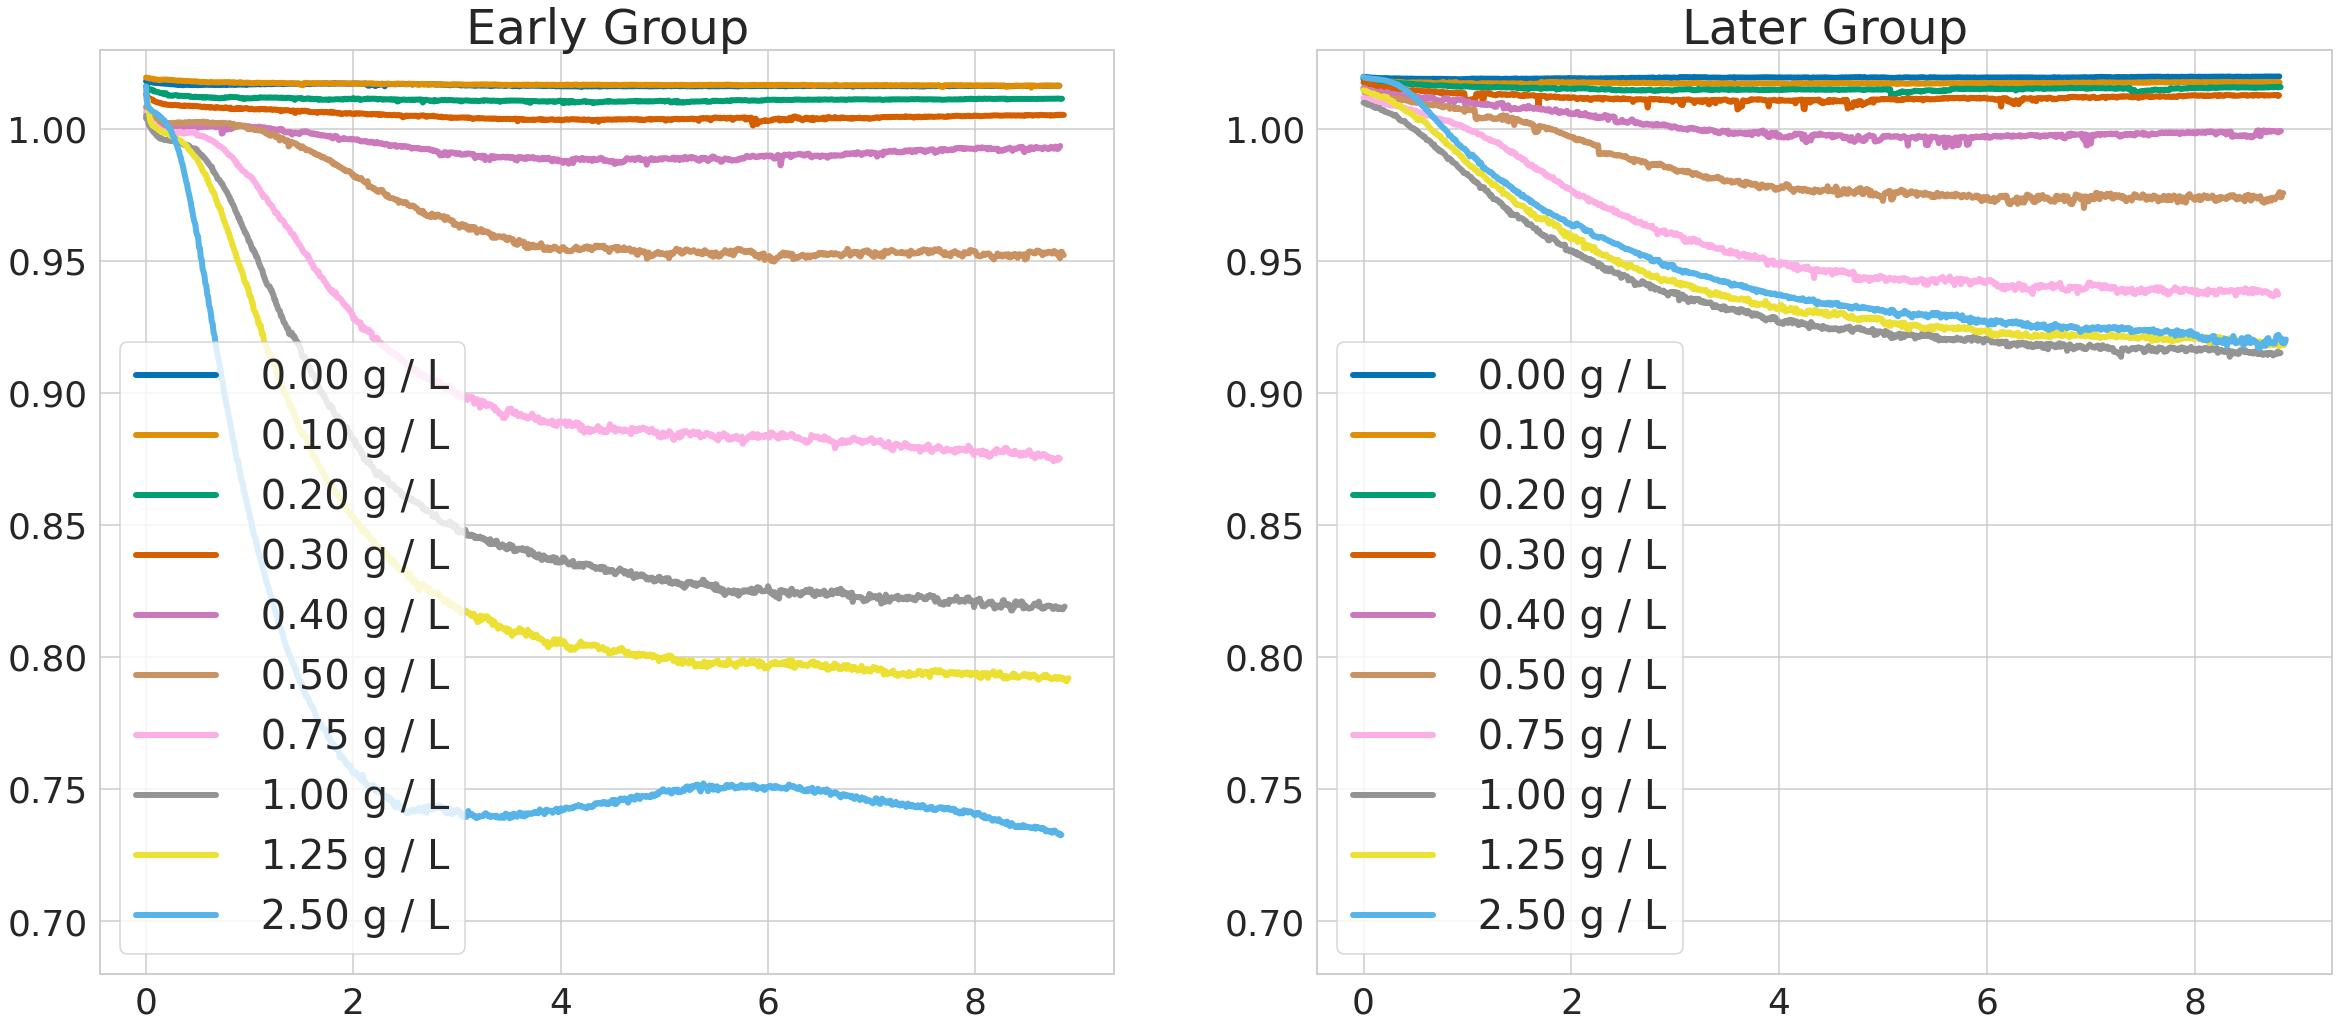

In [227]:
import itertools
from matplotlib.pyplot import cm


def plot_by_group(base_path, split_time, max_time=(100, 100)):
    all_curves = [
        glucose_ts.data.read_glucose_ts(
            os.path.join(base_path, one),
            comment=int(tuple([int(number) for number in one.split('__')[1].split('_')[:2]]) > split_time),
        )
        for one in tuple(
            os.walk(base_path)
        )[0][2]
        if tuple([int(number) for number in one.split('__')[1].split('_')[:2]]) < max_time
    ]
    distinct_concentrations = sorted(list(set([one.real_concentration for one in all_curves])))
    color_mapping = {
        concentration: color 
        for concentration, color in zip(
            distinct_concentrations,
            sns.color_palette('colorblind', len(distinct_concentrations)),
        )
    }
    
    series = itertools.groupby(
        sorted(
            all_curves,
            key=lambda one: (one.comment, one.real_concentration)
        ),
        key=lambda one: one.comment
    )


    fig, axises = plt.subplots(
        1,
        2,
        figsize=(40, 17)
    )
    titles = {0: 'Early Group', 1: '4 Hours Later Group'}
    
    with sns.plotting_context(
            "talk",
            rc={
                "axes.titlesize": 48,
                "axes.labelsize": 40,
                "lines.linewidth": 6,
                "lines.markersize": 10,
                'legend.fontsize': 40,
                'figsize': (17, 40),
            }
        ):


        for (one_concentration, one_group), ax in zip(series, axises.flatten()):
            for count, one_series in enumerate(one_group):
                ax.plot(
                    one_series.points_in_time,
                    one_series.voltages,
                    label='%5.2f g / L' % one_series.real_concentration,
                    color=color_mapping[one_series.real_concentration]
                )
            ax.set_title(titles[one_series.comment])
            ax.set_ylim(0.68, 1.03, )
            ax.legend()
            ax.tick_params(axis='both', which='major', labelsize=36)
        return fig

fig = plot_by_group(
    os.path.join(DATA_DIR, 'standards_warm'),
    (19, 30)
)
    
fig.savefig(
    os.path.join(FIG_DIR, 'one_sensor_early_vs_later.png'),
    facecolor='w',
    edgecolor='w',
    transparent=True,
)

# Standards measured at 37 degree with Lucas

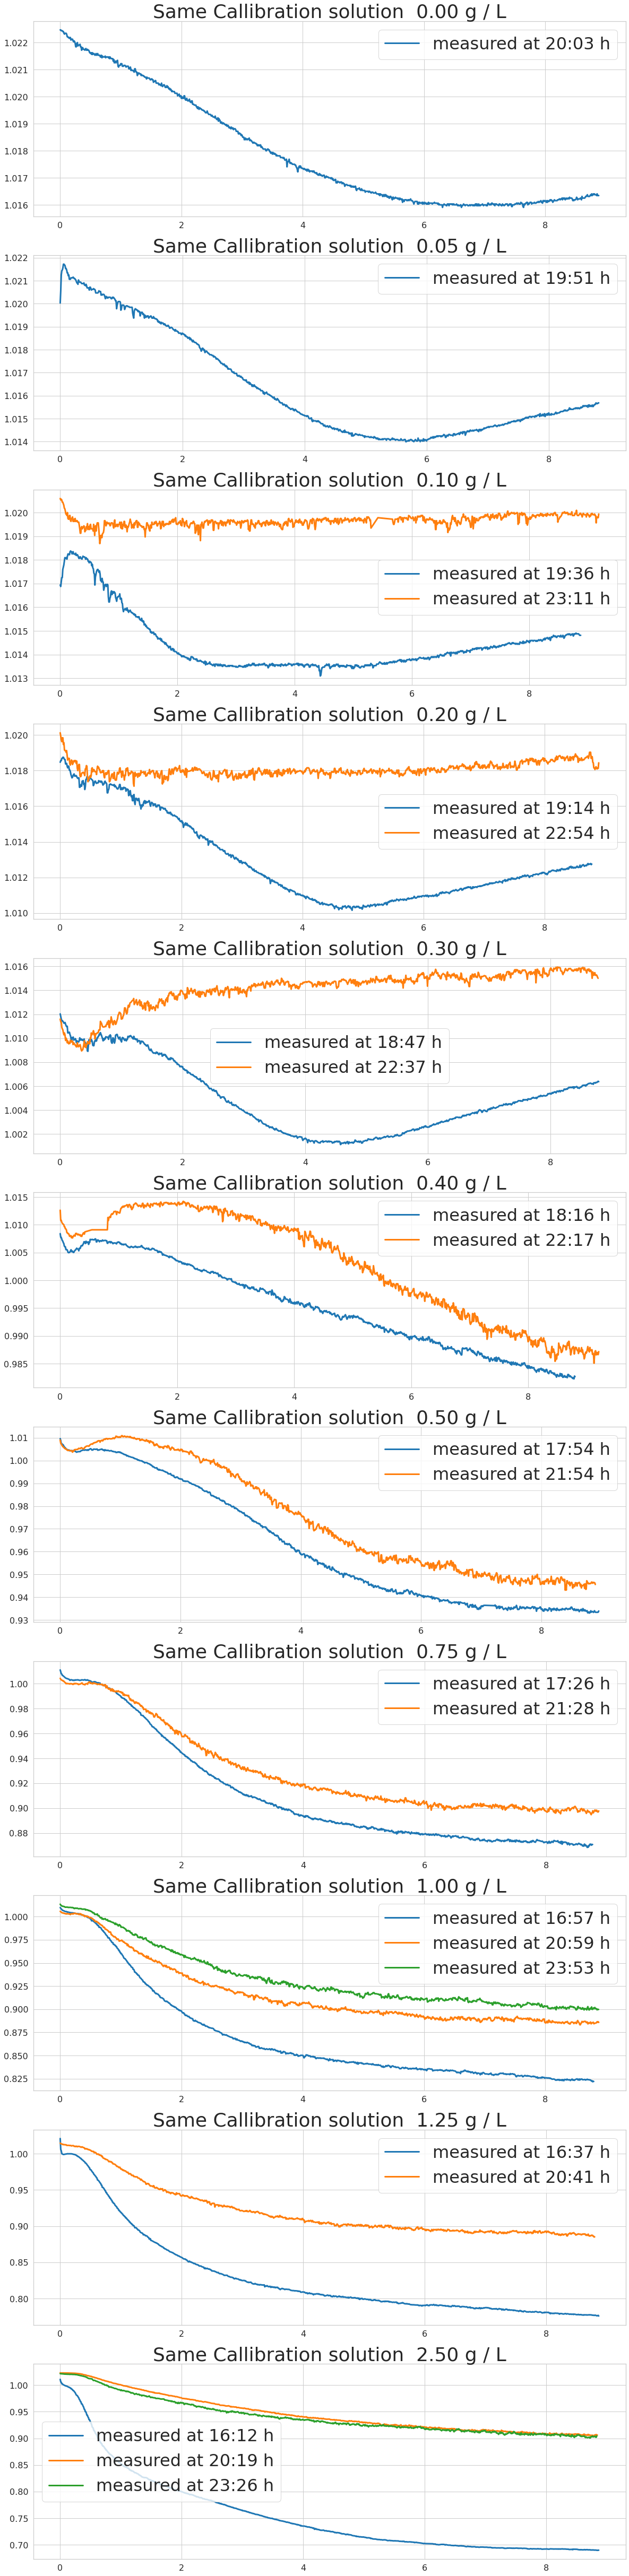

In [9]:
fig = plot_by_concentration(os.path.join(DATA_DIR, 'warm_standards_hamilton'))
    
fig.savefig(
    os.path.join(FIG_DIR, 'sensor_behavior_over_time_warm_hamilton.png'),
    facecolor='w',
    edgecolor='w',
    transparent=True,
)

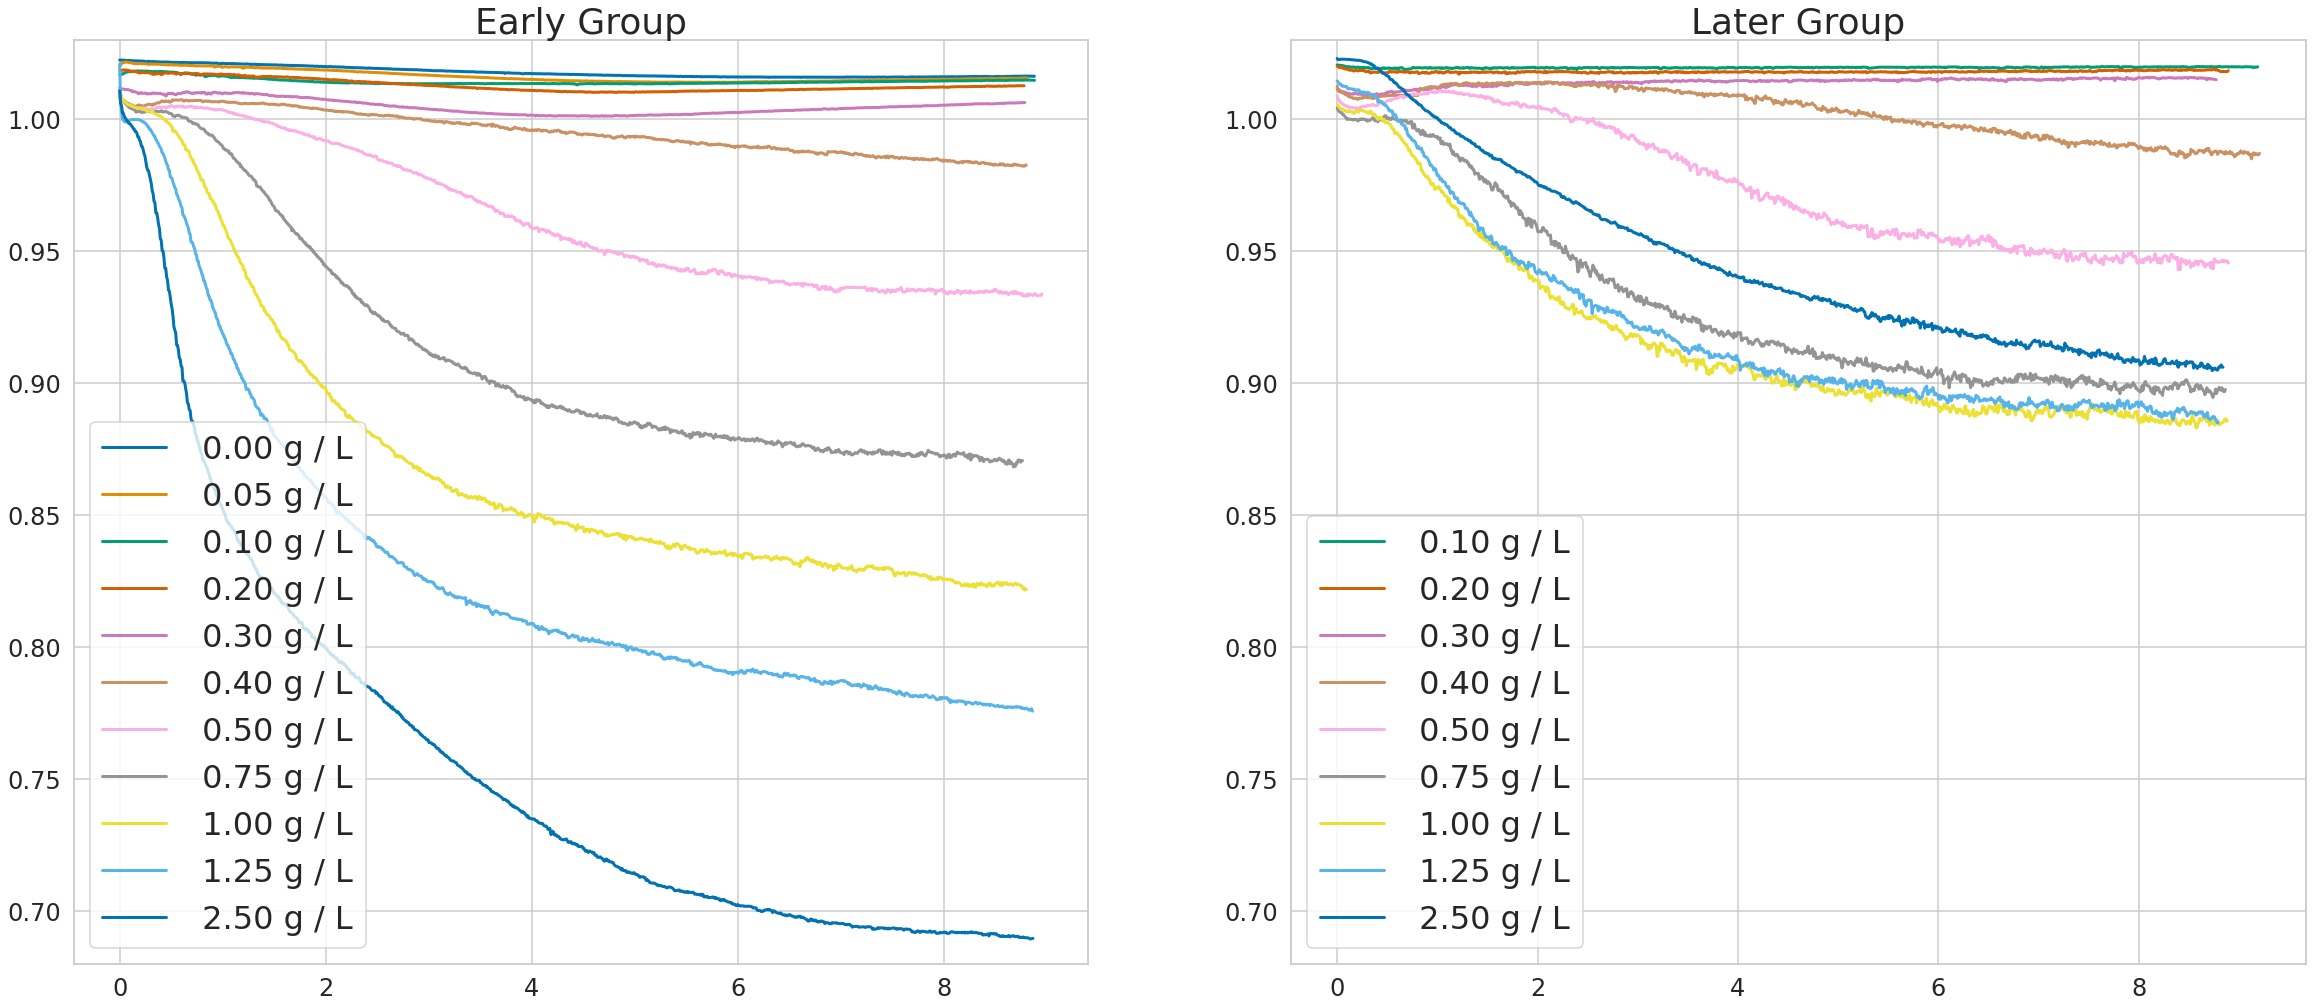

In [207]:
plot_by_group(
    os.path.join(DATA_DIR, 'warm_standards_hamilton'),
    (20, 15),
    (23, 20),
)
    
fig.savefig(
    os.path.join(FIG_DIR, 'sensors_by_group_hamilton.png'),
    facecolor='w',
    edgecolor='w',
    transparent=True,
)

# Two distinct Sensors Group One

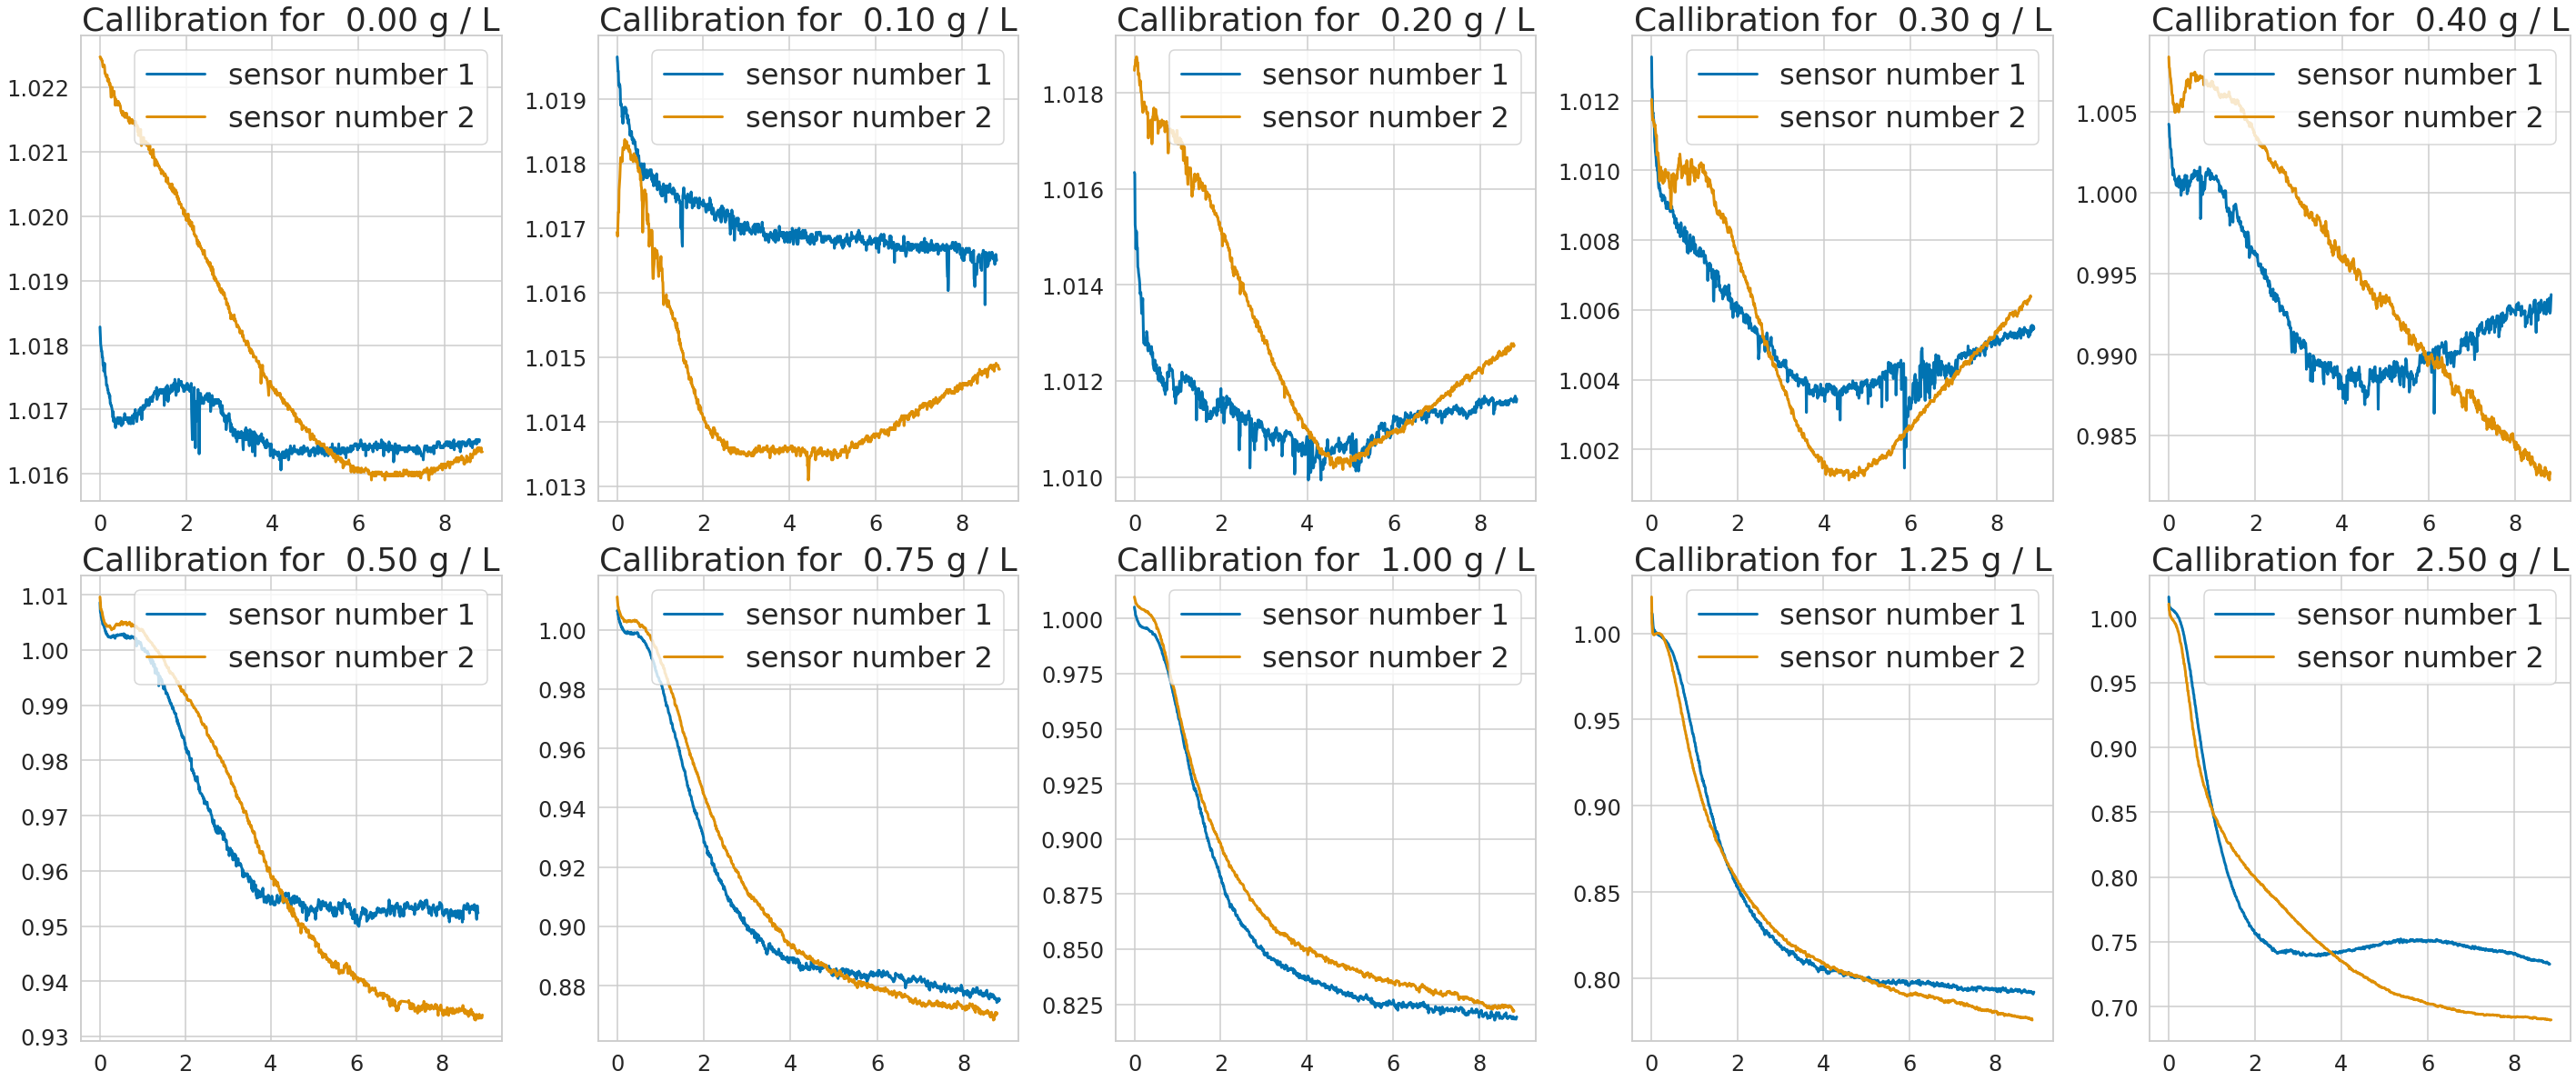

In [202]:
def plot_two_groups_by_concentration(base_path_one, cut_off_one, base_path_two, cut_off_two):
    
    def get_series(base_path, cut_off, sensor_idx):
        all_series = [
            glucose_ts.data.read_glucose_ts(
                os.path.join(base_path, one),
                comment='sensor number %s' % sensor_idx,
            )
            for one in tuple(
                os.walk(base_path)
            )[0][2]
            if tuple([int(number) for number in one.split('__')[1].split('_')[:2]]) < cut_off
        ]
        return {one.real_concentration: one for one in all_series}
    
    series_one = get_series(base_path_one, cut_off_one, 1)
    series_two = get_series(base_path_two, cut_off_two, 2)

    joint_concentrations = set(series_one).intersection(set(series_two))

    fig, axises = plt.subplots(
        int(len(joint_concentrations) / 5),
        5,
        figsize=(4 * len(joint_concentrations), 17)
    )
    fig.tight_layout(pad=2.)
    
    color_list = sns.color_palette('colorblind', 2)
    for one_concentration, ax in zip(sorted(joint_concentrations), axises.flatten()):
        
        one = series_one[one_concentration]
        ax.plot(one.points_in_time, one.voltages, label=one.comment, color=color_list[0])
        two = series_two[one_concentration]
        ax.plot(two.points_in_time, two.voltages, label=two.comment, color=color_list[1])
        ax.set_title('Callibration for %5.2f g / L' % one_concentration)
        ax.legend()
        
    return fig




fig = plot_two_groups_by_concentration(
    os.path.join(DATA_DIR, 'standards_warm'),
    (19, 30),
    os.path.join(DATA_DIR, 'warm_standards_hamilton'),
    (20, 15),
)


fig.savefig(
    os.path.join(FIG_DIR, 'two_sensors_on_callibrations.png'),
    facecolor='w',
    edgecolor='w',
    transparent=True,
    
)
